In [1]:
# 階層ベイズ法
# 階層ベイズ法を使って、年齢から身長を推測する。
# 似たような問題を単回帰分析で行なったが、単回帰分析を使うと母集団全体の推測（＝ある年齢から"一般的に"身長はこうなる）になるが、
# 階層ベイズ法ではベイズ推定によって、ある特定の人物に関する予測が可能になる

# 仮説
# (1) 身長には個人差があり、a[i]x + b[i]と表せる
#   a[i] = a0 + a_id   // a0:全員が共通する傾き、a_id:個人差の傾き
#   b[i] = b0 + b_id   // b0:全員が共通する切片、b_id:個人差の切片
# (2) yと個人差は正規分布に従う。
#   個人差について、身長は平均値（a0,b0）が最も多く、平均的な身長から大きく・小さくなっていくほど人数が少なくなると仮定している。

# 統計モデル
# Y[n] ~ Normal(a[n]x + b[n], σ)   ← ここは単回帰と同じ。身長をax+bで予測する
# a[n] = a0 + a_id[n], a_id[n] ~ Normal(0, σ_a)   ← ここが単回帰と違う。個人差をσの正規分布とおいて、σ_a → a → yというように、
# b[n] = b0 + b_id[n], b_id[n] ~ Normal(0, σ_b)　　　2階層に分けて計算している。そのために"階層"ベイズ法と呼ばれる。

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_csv("./data/multilevel_modeling.csv")

In [4]:
df.head()

# id:個人ID, age:測定したときの年齢, height:身長[cm]

,age,height,id
0,1,72.7,1
1,3,85.7,1
2,5,98.6,1
3,8,117.3,1
4,10,130.1,1


In [5]:
df["id"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [6]:
# id毎の身長の遷移をグラフで表す
groups = df.groupby(df["id"])

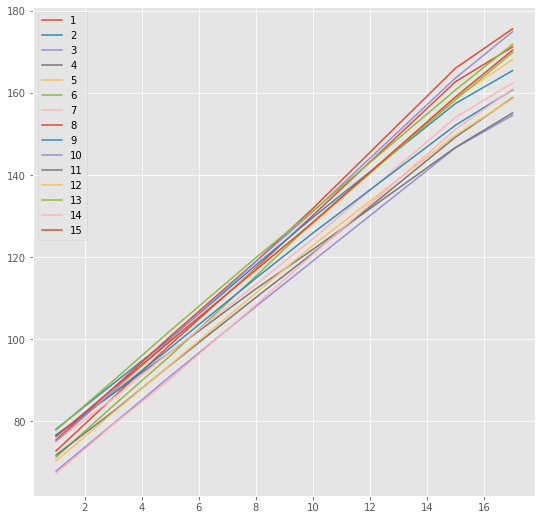

In [7]:
plt.figure(figsize=(9,9))
for name, group in groups:
    plt.plot(group["age"], group["height"], label=name)
plt.legend()

In [8]:
stan_model = """
data {
  int N;
  int N_id; // 15（人数分）
  real X[N]; // 年齢配列
  real Y[N]; // 身長配列
  int <lower=1, upper=N_id> s_id[N]; // データ毎のid（[0]=1(id=1,age=1) [1]=1(id=1,age=3),...[17]=2(:id=2,age=1),...）
}

parameters {
  real a0; // 共通
  real b0;
  real a_id[N_id]; // 個人差
  real b_id[N_id];
  real <lower=0> s_a;
  real <lower=0> s_b;
  real <lower=0> s_Y;
}

// parametersで定義されたパラメータを、変形したパラメータ
transformed parameters {
  real a[N_id]; // 個人の、共通部分を含めた傾き
  real b[N_id]; // 個人の、共通部分を含めた切片
  for (n in 1:N_id) {
    a[n] = a0 + a_id[n];
    b[n] = b0 + b_id[n];
  }
}

model {
  // 正規分布に従った個人差を生み出すためのループ
  for (id in 1:N_id) {
    a_id[id] ~ normal(0, s_a);
    b_id[id] ~ normal(0, s_b);
  }
  
  for (n in 1:N) {
    Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]], s_Y);
  }
}
"""

In [9]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_de74d979ff8792393299b4f66c221e34 NOW.


In [10]:
stan_data = {"N":df.shape[0], "N_id":15, "X":df["age"], "Y":df["height"], "s_id":df["id"]}

In [11]:
fit = sm.sampling(data=stan_data, iter=3000, warmup=1000, chains=3, seed=123)

In [12]:
fit

# Rhat=1.0なので値は収束しているし、se_meanも小さいので信頼できそうな結果になっている
# 単回帰、重回帰分析とは大きく異なる点はa_id, b_idで、個人毎の傾きと切片を計算していること
# 例えば傾きに着目すると、a0でおおよそ平均的な傾きが計算しており、そこから個人差a_idで調節している
# id=1の人を考えると、5.77+0.46=6.23となっており、他人と比べて身長の成長率が高いと考えられる

Inference for Stan model: anon_model_de74d979ff8792393299b4f66c221e34.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0         5.77  4.6e-3   0.12   5.54   5.69   5.77   5.84   6.01    671   1.01
b0        68.17    0.04   0.99  66.16  67.58  68.18  68.78  70.13    767    1.0
a_id[1]    0.46  4.6e-3   0.13    0.2   0.38   0.46   0.55   0.72    823   1.01
a_id[2]   -0.19  4.6e-3   0.13  -0.46  -0.28  -0.19  -0.11   0.08    833   1.01
a_id[3]   -0.29  4.6e-3   0.13  -0.56  -0.37  -0.29   -0.2  -0.03    816   1.01
a_id[4]    -0.8  4.6e-3   0.13  -1.06  -0.88   -0.8  -0.71  -0.54    807   1.01
a_id[5]    0.09  4.7e-3   0.13  -0.17 1.9e-3   0.09   0.17   0.36    811   1.01
a_id[6]    0.41  4.6e-3   0.13   0.15   0.32   0.41   0.49   0.67    801   1.01
a_id[7]   -0.21  4.6e-3   0.13  -0.48  -0.29  -0.21  -0.13   0.05    832   1.01
a_id[8]    

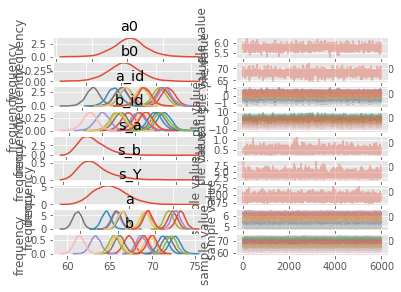

In [13]:
fig = fit.plot()

In [14]:
# ベイズ信頼区間を求めて、どの程度精度よく推定できているか、確認する
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [15]:
# id=1の人だけ求める
x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
    df_b[i] = ms_a[:, 0] * x[i] + ms_b[:, 0]

In [16]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

In [17]:
df_0 = groups.get_group(1)

In [18]:
df_0.head()

,age,height,id
0,1,72.7,1
1,3,85.7,1
2,5,98.6,1
3,8,117.3,1
4,10,130.1,1


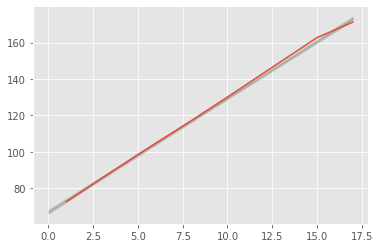

In [19]:
plt.plot(df_0["age"], df_0["height"])
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")

# このモデルは信頼区間が狭いので、精度よく予測できる
# 階層ベイズでは、共通部分+固有の変数を使って推定するため、
# 個人毎の推定がうまくできていることがわかる